<a href="https://colab.research.google.com/github/claudevandort/UAI-DeepLearning/blob/master/03_NeuralNetworksMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <img src='https://github.com/jbekios/UAI-1-2021/blob/main/S02/images/small-uai.jpeg?raw=1'style="width: 300px;">
</center>

## Laboratorio S03.1: Redes neuronales poco profundas y aprendizaje

#### Curso: Aprendizaje profundo
   
<center>
    <img src='https://www.diegocalvo.es/wp-content/uploads/2017/07/perceptron-monocapa.png'style="width: 400px;"><br />
    https://www.diegocalvo.es/clasificacion-de-redes-neuronales-artificiales/
</center>

**Profesor**: Dr. Juan Bekios Calfa

**Grado**: MIA

# Introducción

En este tutorial veremos dos implementaciones en Pytorch una con clasificación lineal multiclase y otra utilizando una red neuronal poco profunda. La idea es poder comparar el rendimiento de ambos clasificadores.

Como se verá, los modelos de entrenamiento implementados en Pytorch requieren mucho menos código que es escribir un proyecto desde cero como se vió en los laboratorios anteriores.

Sin embargo, Pytorch oculta muchos detalles en sus cálculos. Que serán estudiados aquí. 

**Objetivos:**
- Estudiar el conjunto de base de datos MNIST, que contiene imágenes de $28\times 28$ píxeles escritos a mano.
- Introducir el uso de Pytorch para construir y entrenar modelos
- Explorar ajustes del modelo: Tamaño del conjunto de datos, tamaño del *batch* y regularización.


# Introducción

**Base de datos**

El conjunto de datos del MNIST contiene dígitos (numéricos) escritos a mano en blanco y negro de $28\times 28$ píxeles de tamaño. Este es un
conjunto de datos que se utiliza típicamente para demostraciones de modelos de aprendizaje de automático, y como un primer conjunto de datos para probar nuevos
tipos de modelos.

Para el laboratorio descargaremos este conjunto de datos. Para simplificar, sólo usaremos las primeras 2500 imágenes del conjunto de datos del MNIST.

In [ ]:
# Bajar los archivos MNIST manualmente
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [1]:
from torchvision import datasets

# Cargar el conjunto de datos
# Las imágenes son cargadas por torchvision en formato PIL (Python Imaging Library)
# mnist_train = datasets.MNIST('./', train=True, download=True)
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)

print(len(mnist_train))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
60000


## 1. Visualizando y explorando los datos

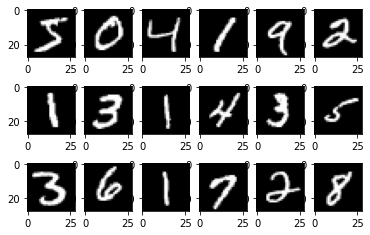

In [2]:
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(mnist_train[:18]):
  plt.subplot(3, 6, k+1)
  plt.imshow(image, cmap='gray')

PyTorch tiene funciones convertir una imagen en características numéricas de píxeles. El tensor aún conserva la geometría 2D de la imagen (aún obtenemos una forma de $1\times 28\times 28$). Para el ejercicio, hay que aplanar la imagen en un vector (para obtener un $1\times 784$
forma).


## 2. Preparando los datos

In [3]:
from torchvision import transforms
# transformamos el tipo de dato de imagen a una matriz de 28x28
img_to_tensor = transforms.ToTensor()
# convertir la última imagen vista (8) dentro de un tensor.
print(image)
img_tensor = img_to_tensor(image)
img_tensor.shape

<PIL.Image.Image image mode=L size=28x28 at 0x7FADA34670D0>


torch.Size([1, 28, 28])

Si queremos convertir la base de datos completa a representación de tipo Tensor. Se puede cargar de la siguiente forma:

In [4]:
mnist_train = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)

print('Tamaño de la primera imagen en formato de tensor:',mnist_train[0][0].shape)
print('Etiqueta o valor clase de la primera  imagen:',mnist_train[0][1])

Tamaño de la primera imagen en formato de tensor: torch.Size([1, 28, 28])
Etiqueta o valor clase de la primera  imagen: 5


Ahora, dividiremos estos datos en **entrenamiento** y **validación**, y empezaremos a construir nuestro modelo. No necesitaremos un conjunto de **pruebas** para esto
pero en general también tendremos que contruir un conjunto de pruebas en los próximos laboratorios.

In [5]:
print('Tamaño conjunto original:', len(mnist_train))
mnist_train, mnist_val = mnist_train[:40000], mnist_train[40000:]
print('='*50)
print('Nuevo tamaño conjunto de entrenamiento: ', len(mnist_train))
print('Nuevo tamaño conjunto de validación: ', len(mnist_val))

Tamaño conjunto original: 60000
Nuevo tamaño conjunto de entrenamiento:  40000
Nuevo tamaño conjunto de validación:  20000


## 3. Modelo lineal multiclass con Pytorch

Para construir un modelo lineal en PyTorch, crearemos una instancia de la clase `nn.Linear`, y especificamos el número de entrada y el número de características de salida. Para la regresión lineal y la clasificación binaria, el número de salida características es 1. Para la clasificación de clases múltiples, tenemos tantos resultados como clases hay.

Al usar este modelo para la clasificación, necesitaremos aplicar la activación sigmoide o softmax después. Es decir, este objeto sólo está destinado a manejar la parte lineal del cálculo del modelo.


In [6]:
import torch
import torch.nn as nn

example_model = nn.Linear(50, 1) # Asumimos 50 features y una salida lineal

El objeto `example_model` contiene los **pesos** y los **sesgos** de el modelo. Por defecto, **PyTorch inicializa** esos valores con **números aleatorios cercanos a cero**.

In [7]:
weight, bias = list(example_model.parameters())
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-0.0311,  0.1119, -0.1404, -0.1187, -0.0826, -0.1388,  0.0789, -0.0116,
         -0.1002,  0.0970, -0.0307,  0.0246, -0.1313,  0.0296, -0.0018, -0.0023,
         -0.0905, -0.0278, -0.0257, -0.0811,  0.0432,  0.0252,  0.0431, -0.0036,
         -0.0624,  0.1405,  0.0869, -0.0237,  0.0005,  0.0246, -0.1388,  0.0989,
         -0.0029, -0.0736, -0.0408,  0.1018, -0.0926, -0.0728,  0.0426,  0.1345,
         -0.0672, -0.1041,  0.1213,  0.0673,  0.0547,  0.0519,  0.0031, -0.0142,
          0.0108, -0.0277]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.1240], requires_grad=True)
torch.Size([1])


Si creamos un nuevo modelo, sus parámetros iniciales cambiarán.

In [8]:
example_model = nn.Linear(50, 1)
weight, bias = list(example_model.parameters())

# Los valores son diferentes a los de arriba
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-0.0257,  0.0476,  0.0182,  0.0429, -0.0327,  0.1372, -0.0506, -0.0330,
         -0.1346, -0.0235, -0.1008,  0.0129,  0.0152,  0.0619,  0.1205,  0.0844,
          0.0068, -0.1247,  0.1058, -0.0168, -0.1014,  0.0564, -0.0386,  0.0525,
         -0.1132, -0.0119, -0.0987,  0.1129, -0.1360,  0.1142,  0.0710, -0.1191,
         -0.0509, -0.0918,  0.0734,  0.0480, -0.0368,  0.0803,  0.0233, -0.0752,
         -0.1063, -0.1206, -0.1163,  0.0635,  0.0735,  0.0344,  0.0074,  0.1316,
         -0.0787, -0.0518]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.0151], requires_grad=True)
torch.Size([1])


### Modelo lineal multiclase

Ahora, vamos a crear el modelo real que entrenaremos para resolver el problema de clasificación de dígitos del MNIST. ¿Cuántos
características de entrada que tenemos? ¿Cuántas características de salida necesitamos?

*  ¿Cuántas características (entrada) necesitamos para resolver este problema? 

*  ¿Cuántas características de salida necesitamos?

In [9]:
# RESPUESTA:

model = nn.Linear(784, 10) # 784 = 28*28
print(model)

# Verifiquemos que las formas de los pesos y los sesgos son lo que esperamos
weight, bias = list(model.parameters())
print(weight.shape)
print(bias.shape)

Linear(in_features=784, out_features=10, bias=True)
torch.Size([10, 784])
torch.Size([10])


## 4. Haciendo predicciones

Veamos cómo podemos hacer una predicción con este modelo. (Puede que parezca extraño que estemos hablando de cómo
hacer predicciones antes de hablar de cómo entrenar el modelo. La razón es que siempre entrenaremos el modelo
utilizando una variante de descenso de gradiente. Así que puedes imaginar que los pesos de este modelo se convertirán eventualmente en más
significativo de lo que es ahora)

Empezaremos con el modelo de ejemplo más simple primero. La forma en que hacemos las predicciones es comenzando con una entrada
x que tiene la forma requerida. Ya que `example_model` es sólo un ejemplo, crearemos un tensor con la apropiada forma, llena de valores aleatorios.

In [10]:
x = torch.randn(50) # Crear un tensor de rango 1 con 50 características
print(x)
x.shape

tensor([-0.8523,  1.4904,  0.7749, -0.0405, -0.4727, -0.5515,  1.2480, -0.1700,
         0.5752, -1.4342,  0.8888, -0.0769, -0.9204, -0.2181,  1.7141,  0.4629,
         1.1311,  0.7248,  0.1636, -0.1149,  1.8863,  0.5667, -0.0933, -0.5824,
        -1.8885, -1.8294,  0.6501, -1.8615, -0.0201,  1.0586,  0.4166, -0.3456,
        -0.9857,  0.3845, -1.1456, -0.2479, -0.2634,  1.2502,  0.9667, -0.5766,
         1.0544, -1.5015, -0.0114,  1.5578, -0.2441,  2.0662, -0.6604,  1.7668,
         1.2773, -0.4045])


torch.Size([50])

Para hacer predicciones, aplicamos el `example_model` como si fuera una función, con las entradas como argumento:

In [11]:
y = example_model(x)
print(y)
y.shape

tensor([0.4275], grad_fn=<AddBackward0>)


torch.Size([1])

Si este modelo se utilizara para la **clasificación binaria**, también podríamos necesitar aplicar la función sigmoide:

In [12]:
torch.sigmoid(example_model(x))

tensor([0.6053], grad_fn=<SigmoidBackward>)

Una buena noticia  de PyTorch es que vectoriza y paraleliza el cálculo para nosotros. Así que, si tuviéramos un lote de 32
entradas para las que queremos hacer predicciones, podemos realizar ese cálculo usando una sola llamada:

In [13]:
x = torch.randn([32, 50]) # pila de  32 entradas
print(x.shape)
y = example_model(x)
print(y.shape)

torch.Size([32, 50])
torch.Size([32, 1])


(Nota: El orden de las dimensiones en nuestra entrada $x$ importa. El tamaño del *batch size* **siempre va primero**, y el **número de características** siempre va en **segundo lugar**) ¡Ahora, tratemos de hacer algunas "predicciones" con nuestro modelo MNIST! Todavía tenemos la variable image_tensor de
antes:

###Base de datos MNIST.

* Imágenes de $28\times 28$ pixeles.
* Una etiqueta por cada imágen. (Número entero)

In [14]:
# Imágenes MNIST
img_tensor.shape

torch.Size([1, 28, 28])

Sin embargo, la forma de este tensor no es lo que necesitamos ahora. Necesitamos aplanar la imagen en un rango 1
tensor (con forma [784] - que representan una imagen de $28\times 28$) o un tensor de rango 2 (con forma [1, 784]). Escogeremos este último, para que la transición a
pasar varias imágenes al mismo tiempo es más fácil:

In [15]:
x = img_tensor.view(1, 784)
print(x.shape)
z = model(x)
print(z)
print(z.shape)
y = torch.softmax(z, dim=1)
print(y) # "Probabilidad"
#print(torch.sum(y))

torch.Size([1, 784])
tensor([[ 0.3288, -0.1240, -0.0167,  0.2652,  0.3888, -0.2698,  0.2907,  0.2291,
         -0.1322,  0.1754]], grad_fn=<AddmmBackward>)
torch.Size([1, 10])
tensor([[0.1212, 0.0771, 0.0858, 0.1137, 0.1287, 0.0666, 0.1167, 0.1097, 0.0764,
         0.1040]], grad_fn=<SoftmaxBackward>)


El `dim=1` en el _softmax_ le dice a PyTorch qué dimensión representa las diferentes imágenes, y cuál representa la
etiquetas de diferentes clases. Queremos que nuestros resultados sean una distribución de probabilidad entre las clases, y no las diferentes
imágenes.

## 5. Función de pérdida

Para que la red sea útil, necesitamos entrenarla, para que los pesos sean realmente significativos,
valores no aleatorios. Como se mencionó antes, usaremos la red para hacer predicciones, luego compararemos las predicciones
contra las observaciones reales a través de la función de pérdida.
PyTorch tiene funciones de pérdida estándar que podemos usar: por ejemplo, `nn.BCEWithLogitsLoss()` para una **clasificación binaria**
y un `nn.CrossEntropyLoss()` para un problema de **clasificación multiclase** como el nuestro.

In [16]:
criterion = nn.CrossEntropyLoss()

Este criterio también puede ser llamado como una función. Toma como parámetros la predicción de *logit* y las etiquetas reales, y
devuelve la pérdida. Dos cosas a tener en cuenta para esta función:

1. Las **funciones de pérdida** como esta normalmente toman el *logit* como parámetro, en lugar de las distribuciones de probabilidad post-softmax. Esto es para la estabilidad numérica.
2. Esta **función de pérdida** también toma como parámetro el índice de la etiqueta real, en lugar de un vector de un punto.

In [17]:
loss = criterion(y, torch.Tensor([8]).long()) # digit 8 = the 8-th class
print(loss)

tensor(2.3263, grad_fn=<NllLossBackward>)


## 6. Optimización

PyTorch también calcula las derivadas para nosotros usando la diferenciación automática, de la cual (podríamos) hablar en este curso.
En resumen, podemos especificar un optimizador (como el Descenso de Gradiente Estocástico), y usar el optimizador para determinar cómo
actualizar los pesos.

In [18]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.005) # lr = learning rate
# Tres líneas de código que son requeridas para el rendimiento 
# de actualización del descenso de gradiente:
loss.backward() # Calcula los gradientes
optimizer.step() # Hace las actualizaciones de cada parámetro
optimizer.zero_grad() # Limpia el paso anterior dejado por step()

También podemos utilizar regularización L2 para mantener el suavizado de los parámetros:

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.01)

## 7. Batching

Pytorch nos permite cargar los datos por lotes para implementar el descenso de gradiente estocástico.


In [20]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=32, # batch size
                                           shuffle=True) # Mezclar despues de cada epoch
for index, (xs, ts) in enumerate(train_loader):
  print('Número de batch:', index)
  print('='*50)
  print(xs.shape) # image pixels
  print(ts.shape) # targets
  break

Número de batch: 0
torch.Size([32, 1, 28, 28])
torch.Size([32])


## 8. Código completo

In [22]:
# CODIGO COMPLETO Y EJECUTABLE
import torch.optim as optim

def run_gradient_descent(model,
                      batch_size=32,
                      learning_rate=0.01,
                      weight_decay=0,
                      num_epochs=10):
  # Optimización
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  iters, losses = [], []
  iters_sub, train_acc, val_acc = [], [] ,[]
  train_loader = torch.utils.data.DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True)
  # ENTRENAMIENTO
  n = 0 # Número de iteraciones
  for epoch in range(num_epochs):
    for xs, ts in iter(train_loader):
      if len(ts) != batch_size:
        continue
      xs = xs.view(-1, 784) # Convertir la imagen en un vector
      zs = model(xs)
      loss = criterion(zs, ts) # Calcular el loss total
      loss.backward() # Calcular gradientes
      optimizer.step() # Actualizar parámetros
      optimizer.zero_grad() # Borrar todos los cálculos anteriores en Pytorch
      # save the current training information
      iters.append(n)
      losses.append(float(loss)/batch_size) # Calcular el loss promedio
      if n % 10 == 0:
        iters_sub.append(n)
        train_acc.append(get_accuracy(model, mnist_train))
        val_acc.append(get_accuracy(model, mnist_val))
      # increment the iteration number
      n += 1

  # plotting
  plt.figure(figsize=(20, 4))
  plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(iters, losses, label="Entrenamiento")
  plt.xlabel("Iteraciones")
  plt.ylabel("Loss")
  plt.show()

  plt.figure(figsize=(20, 4))
  plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(iters_sub, train_acc, label="Entrenamiento")
  plt.plot(iters_sub, val_acc, label="Validación")
  plt.xlabel("Iteraciones")
  plt.ylabel("Tasa de acierto")
  plt.legend(loc='best')
  plt.show()

  return model

def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=500)
  correct, total = 0, 0
  for xs, ts in loader:
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # Obtener el índice de la clasificiación (logit)
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
    return correct / total

Ahora podemos entrenar el modelo.

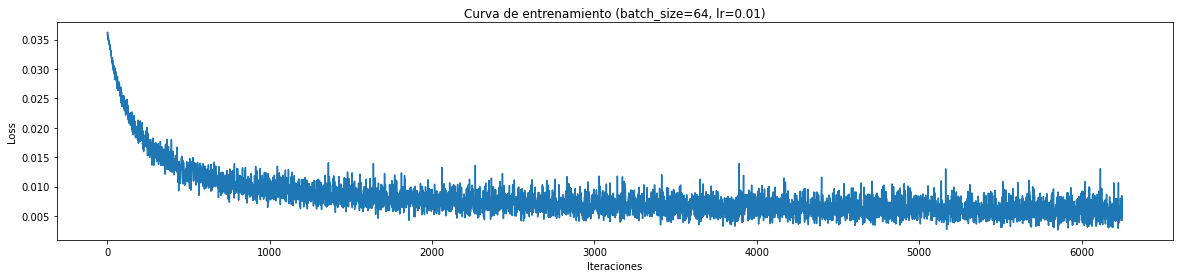

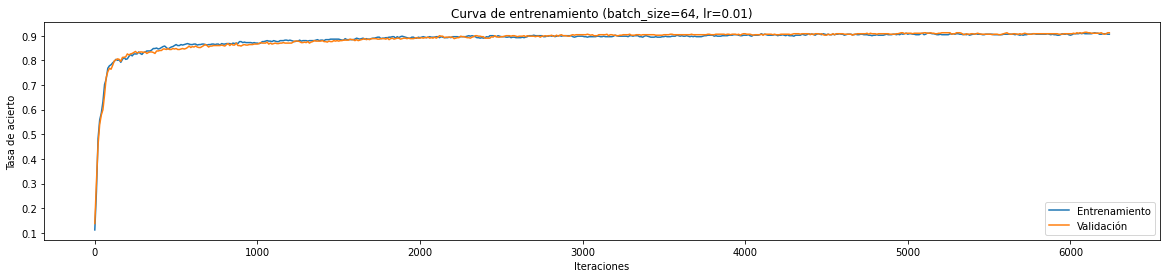

CPU times: user 7.53 s, sys: 302 ms, total: 7.83 s
Wall time: 7.87 s


In [23]:
%%time
model = nn.Linear(784, 10)
run_gradient_descent(model, batch_size=64, learning_rate=0.01, num_epochs=10)

### Matriz de confusión

In [24]:
# Accuracy conjunto de validación
acc_valid = get_accuracy(model, mnist_val)

loader = torch.utils.data.DataLoader(mnist_val, batch_size=20000)

for xs, ts in loader:
    y_pred_logit = model(xs.view(-1, 784))
    y_pred = y_pred_logit.max(1, keepdim=True)[1]

print(ts.shape)
print(y_pred.detach().numpy().shape)


torch.Size([20000])
(20000, 1)


### Analizar vector de pesos

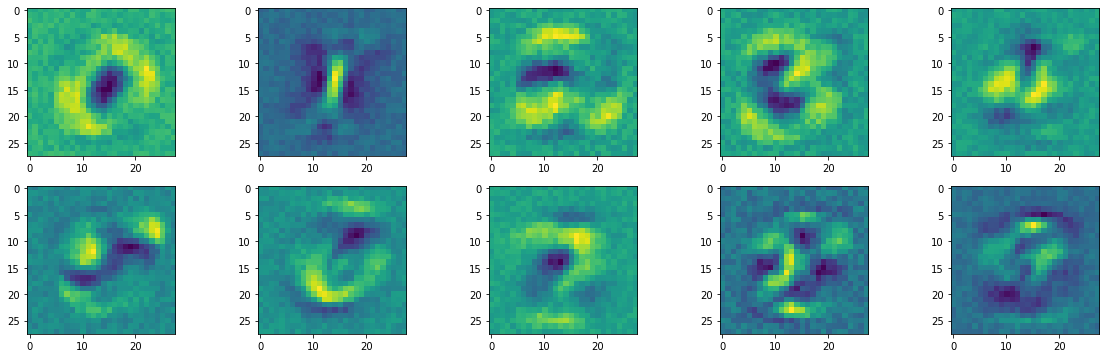

In [25]:
#print(list(model.parameters()))

#for name, param in model.named_parameters():
#    print(name)
#    print(param)
#    print('-'*20)

# Obtengo los parámetros en formato diccionario
d = dict(model.named_parameters())
# Selecciono solo los parámetros que ajunta la regresión lineal
w = d['weight']

import matplotlib.pyplot as plt


f = plt.figure(figsize=(20,6))
# Por cada vector de parámetros pesos grafico (10x728)
for index, template in enumerate(w):
  template = template.detach().numpy().reshape(28,28)
  plt.subplot(2, 5, index+1)
  plt.imshow(template)